In [6]:
import scanpy as sc
import anndata
import os
os.chdir("c:/Users/pedro/OneDrive/Área de Trabalho/spatial_ovary/Ovary_v3")
print(os.getcwd())
sc.set_figure_params(figsize=(6,6), frameon=False)

c:\Users\pedro\OneDrive\Área de Trabalho\spatial_ovary\Ovary_v3


In [7]:
adata = sc.read_10x_h5(f"{os.getcwd()}\\SC_data\\filtereddata.h5")
adata.var_names_make_unique()
adata.X

c:\Users\pedro\OneDrive\Área de Trabalho\spatial_ovary\.venv\Lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\pedro\OneDrive\Área de Trabalho\spatial_ovary\.venv\Lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


<6842x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 24371552 stored elements in Compressed Sparse Row format>

In [8]:
results_file = 'write/SC_ovary.h5ad'

In [9]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

c:\Users\pedro\OneDrive\Área de Trabalho\spatial_ovary\.venv\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\pedro\OneDrive\Área de Trabalho\spatial_ovary\.venv\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\pedro\OneDrive\Área de Trabalho

scanpy==1.9.3 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.11.1 pandas==2.0.3 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.6 pynndescent==0.5.10


c:\Users\pedro\OneDrive\Área de Trabalho\spatial_ovary\.venv\Lib\site-packages\umap\umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [10]:
def pp(h5_path):
    adata = sc.read_10x_h5(h5_path)
    adata.var_names_make_unique()
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)
    adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
    adata = adata[adata.obs.pct_counts_mt < 20]
    sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI
    sc.pp.log1p(adata) #change to log counts
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #these are default values
    adata.raw = adata #save raw data before processing values and further filtering
    adata = adata[:, adata.var.highly_variable] #filter highly variable
    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
    sc.pp.scale(adata, max_value=10) #scale each gene to unit variance
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
    sc.tl.leiden(adata, resolution = 0.25)
    sc.tl.umap(adata)
    return adata

normalizing counts per cell
    finished (0:00:00)


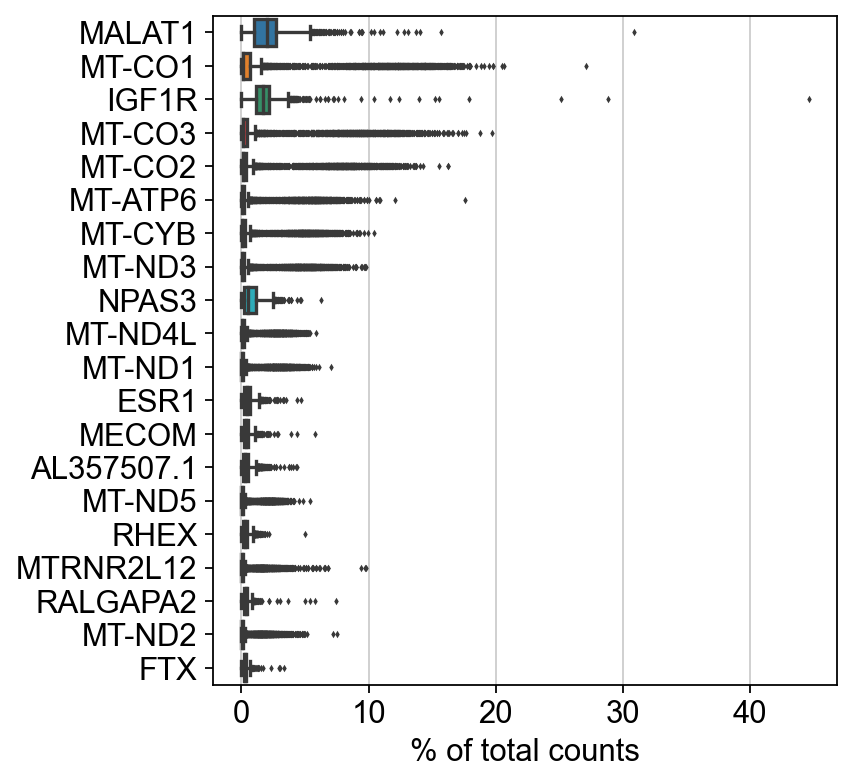

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [12]:
adata.obs["sample"] = "SingleCell_1"
adata

AnnData object with n_obs × n_vars = 6842 × 36601
    obs: 'sample'
    var: 'gene_ids', 'feature_types', 'genome'

In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 3 cells that have less than 200 genes expressed
filtered out 7995 genes that are detected in less than 3 cells


In [14]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")# anotating mt genes as mt
sc.pp.calculate_qc_metrics(adata=adata, qc_vars=["mt"], percent_top=None, inplace=True, log1p=False)

In [15]:
adata.obs.head()

,sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCTGAGATGAGAG-1,SingleCell_1,9059,9058,40057.0,76.0,0.189730
AAACCTGAGCCGGTAA-1,SingleCell_1,3333,3332,6521.0,16.0,0.245361
AAACCTGCACACCGAC-1,SingleCell_1,346,346,765.0,349.0,45.620914
AAACCTGGTAAAGGAG-1,SingleCell_1,275,275,1092.0,748.0,68.498169
AAACCTGGTACCGCTG-1,SingleCell_1,7113,7110,24134.0,133.0,0.551090


c:\Users\pedro\OneDrive\Área de Trabalho\spatial_ovary\.venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


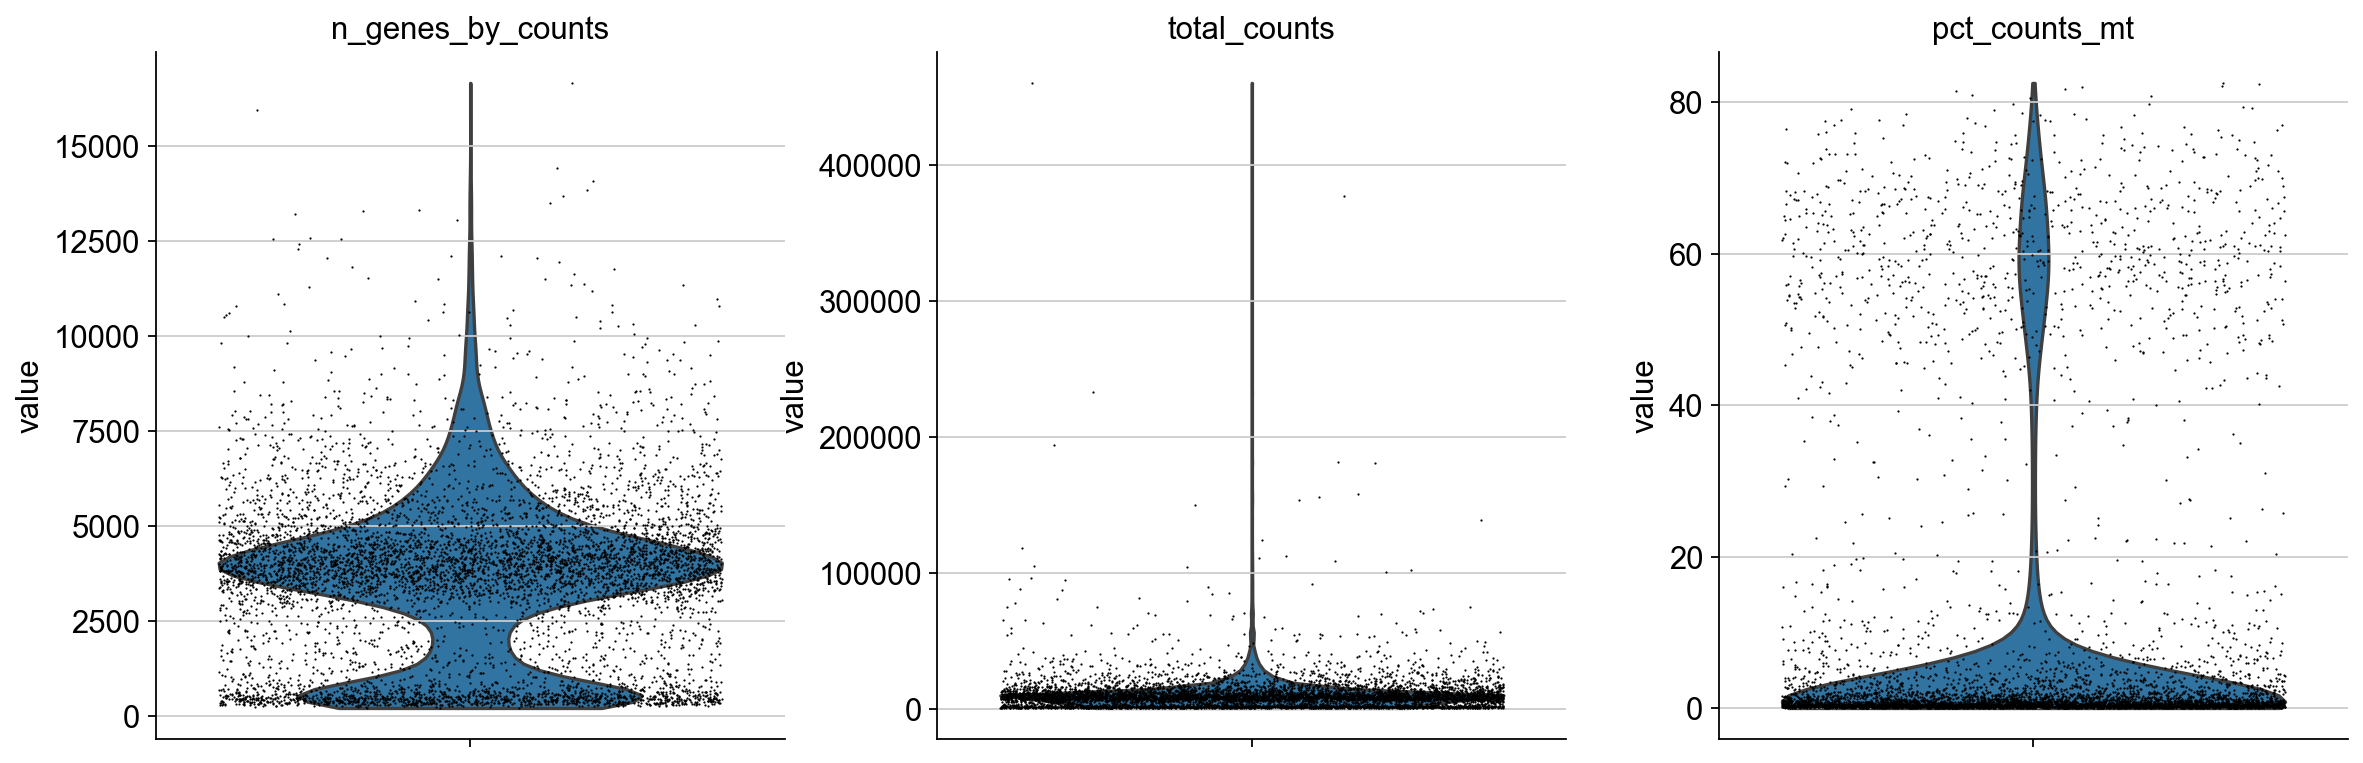

In [16]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

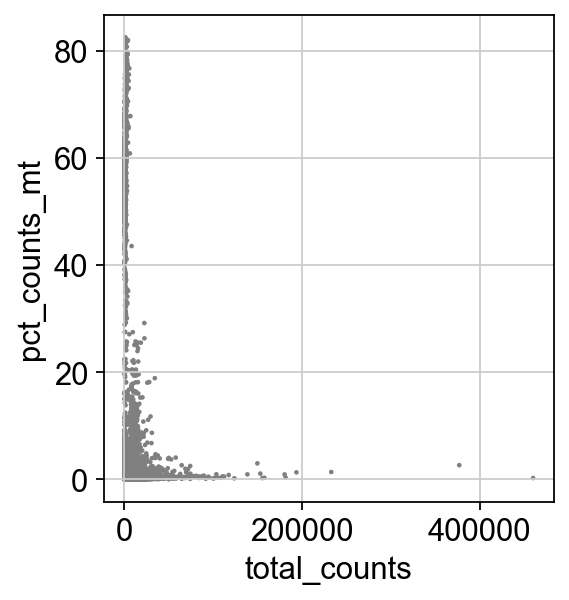

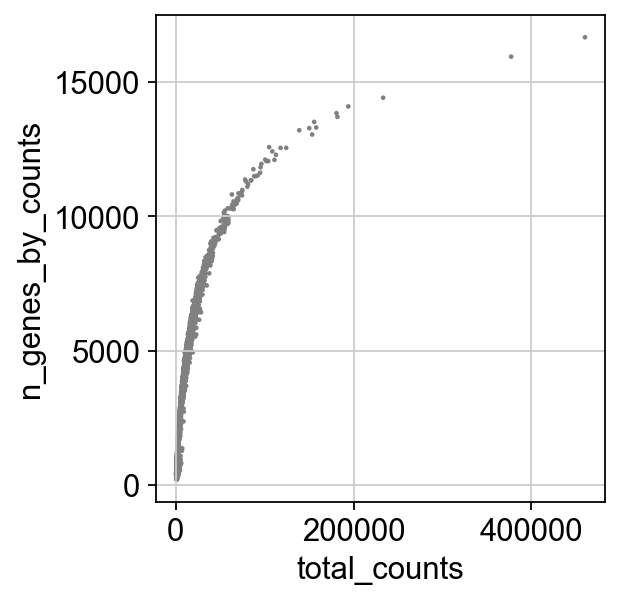

In [17]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [18]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [19]:
adata[:, "FOLR2"].X.shape

(805, 1)

In [20]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


c:\Users\pedro\OneDrive\Área de Trabalho\spatial_ovary\.venv\Lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [21]:
sc.pp.log1p(adata)

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


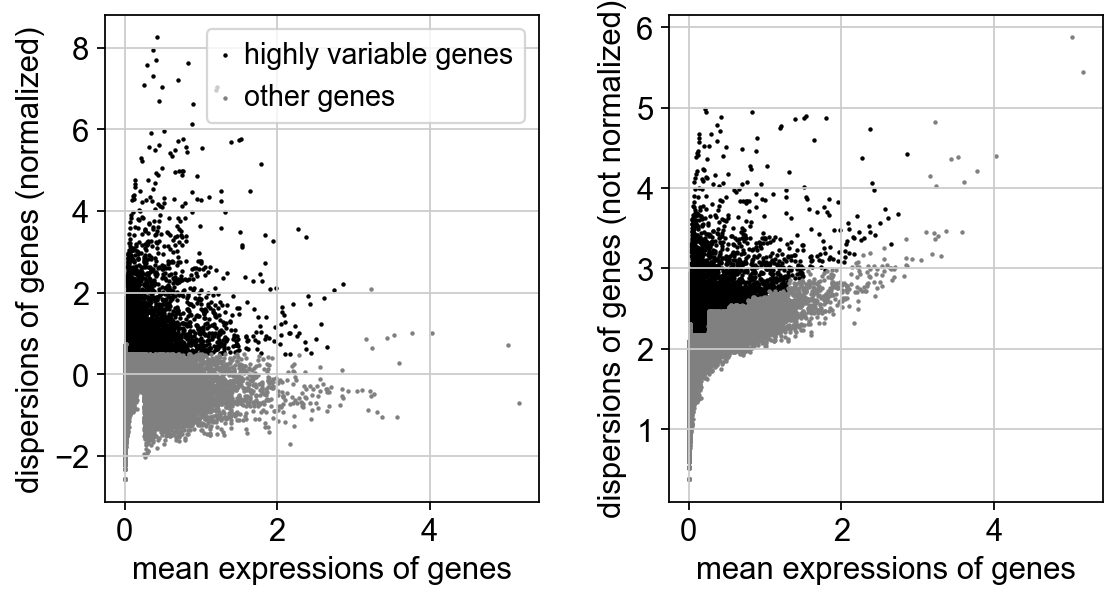

In [23]:
sc.pl.highly_variable_genes(adata)

In [24]:
adata.raw = adata # You can get back an AnnData of the object in .raw by calling .raw.to_adata().

In [25]:
adata

AnnData object with n_obs × n_vars = 805 × 28606
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [ ]:
# sc.pp.highly_variable_genes(
#     adata,
#     n_top_genes=4000,
#     # subset=True, # to automatically subset to the 4000 genes
#     layer="counts",
#     flavor="seurat_v3"
# )

In [ ]:
#adata = adata.raw.to_adata()

In [26]:
adata = adata[:,adata.var.highly_variable]# filtering

In [27]:
adata

View of AnnData object with n_obs × n_vars = 805 × 6469
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [28]:
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


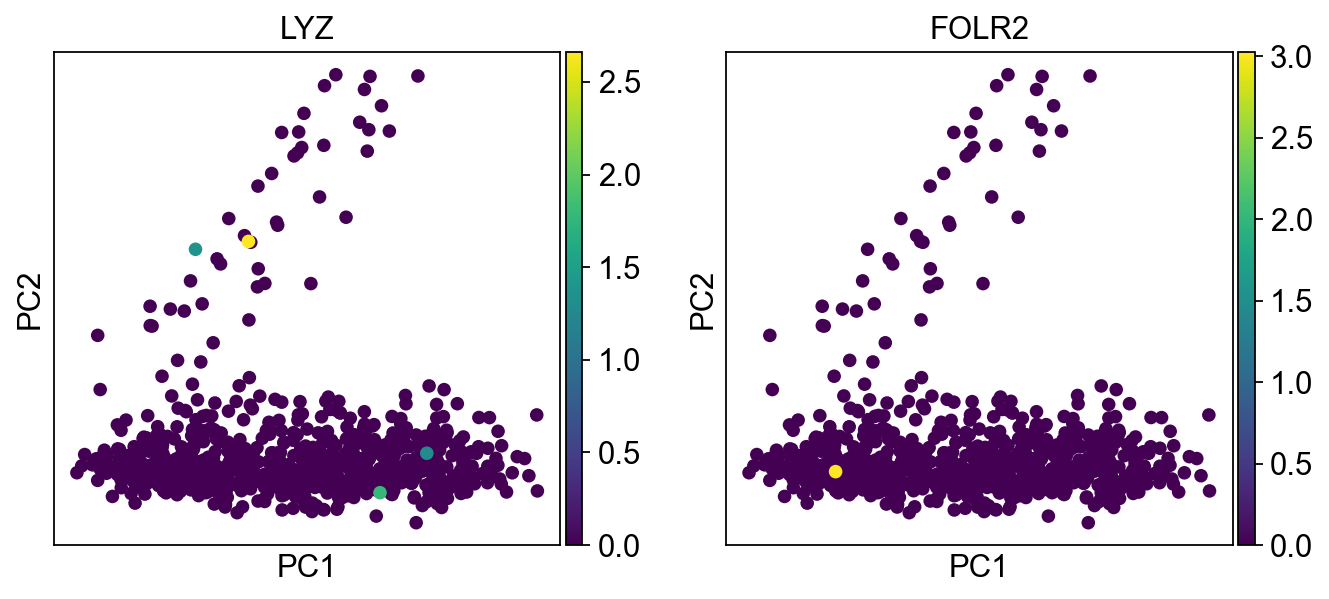

In [29]:
sc.pl.pca(adata, color=["LYZ", "FOLR2"])

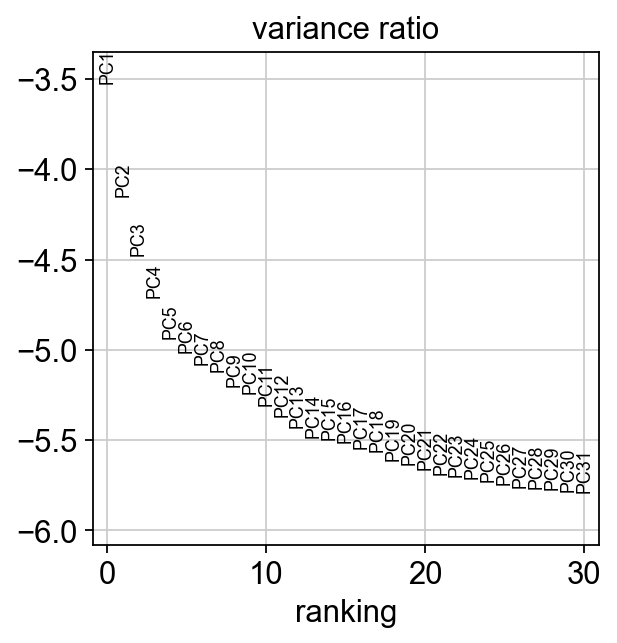

In [30]:
sc.pl.pca_variance_ratio(adata, log=True)

In [31]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [ ]:
sc.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:01)


In [32]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


In [33]:
sc.tl.leiden(adata, resolution=0.5)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


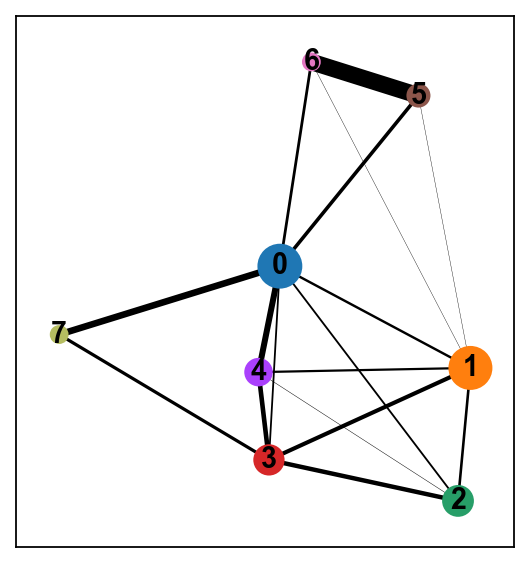

In [34]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=True)# trajectory

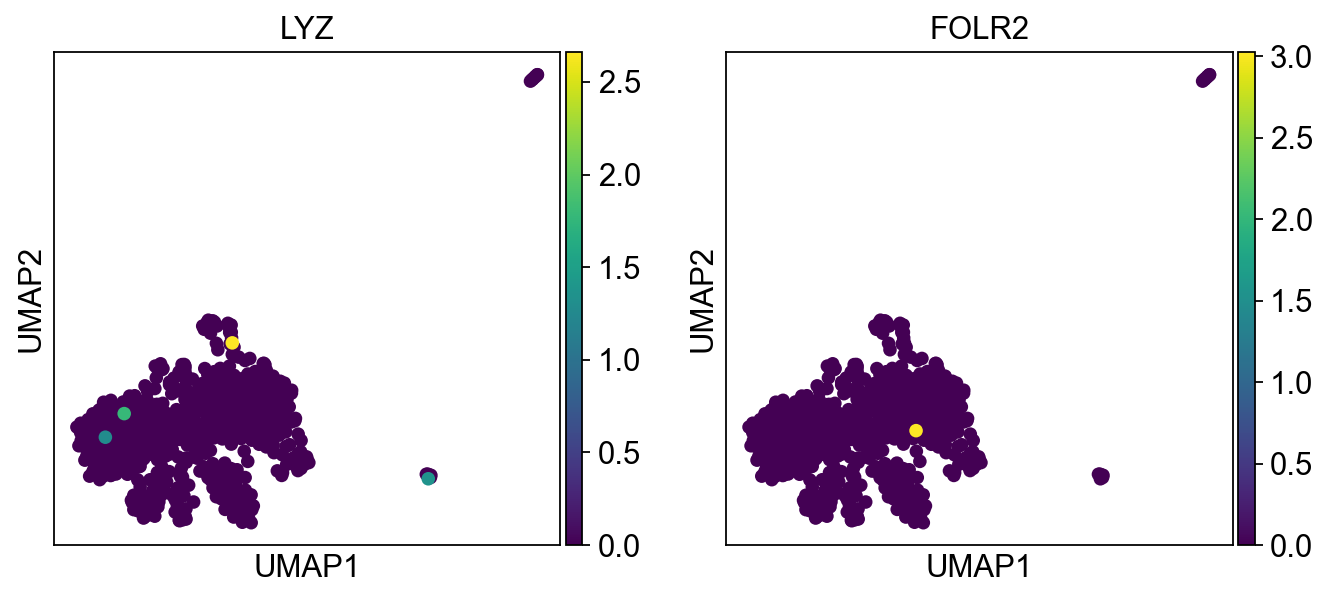

In [35]:
sc.pl.umap(adata, color=["LYZ", "FOLR2"])

c:\Users\pedro\OneDrive\Área de Trabalho\spatial_ovary\.venv\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


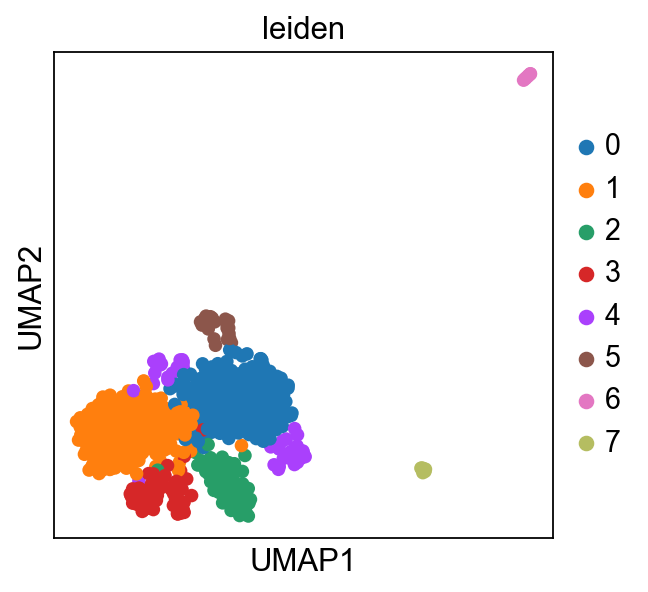

In [36]:
sc.pl.umap(adata, color=["leiden"])

In [37]:
adata

AnnData object with n_obs × n_vars = 805 × 6469
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'paga', 'leiden_sizes', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [38]:
import celltypist
from celltypist import models
import time

In [39]:
adata_cellbygene = sc.read_h5ad("C:\\Users\\pedro\\OneDrive\\Área de Trabalho\\SC_ovary\\SC_data\\local.h5ad")# MTO GRANDE

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'C:\Users\pedro\OneDrive\Área de Trabalho\SC_ovary\SC_data\local.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [39]:
t_start = time.time()
model = celltypist.train("C:\\Users\\pedro\\OneDrive\\Área de Trabalho\\SC_ovary\\SC_data\\local.h5ad")
t_end = time.time()
print(f"Time elapsed: {(t_end - t_start)/60} minutes")

🍳 Preparing data before training


Exception: 🛑 Missing training data and/or training labels. Please provide both arguments

In [251]:
adata_2000 = sc.read('celltypist_demo_folder/demo_2000_cells.h5ad', backup_url = 'https://celltypist.cog.sanger.ac.uk/Notebook_demo_data/demo_2000_cells.h5ad')

In [252]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 19
📂 Storing models in C:\Users\pedro\.celltypist\data\models
💾 Downloading model [1/19]: Immune_All_Low.pkl
💾 Downloading model [2/19]: Immune_All_High.pkl
💾 Downloading model [3/19]: Adult_Mouse_Gut.pkl
💾 Downloading model [4/19]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [5/19]: COVID19_HumanChallenge_Blood.pkl
💾 Downloading model [6/19]: COVID19_Immune_Landscape.pkl
💾 Downloading model [7/19]: Cells_Fetal_Lung.pkl
💾 Downloading model [8/19]: Cells_Intestinal_Tract.pkl
💾 Downloading model [9/19]: Cells_Lung_Airway.pkl
💾 Downloading model [10/19]: Developing_Human_Brain.pkl
💾 Downloading model [11/19]: Developing_Human_Thymus.pkl
💾 Downloading model [12/19]: Developing_Mouse_Brain.pkl
💾 Downloading model [13/19]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [14/19]: Human_IPF_Lung.pkl
💾 Downloading model [15/19]: Human_Lung_Atlas.pkl
💾 Downloading model [16/19]: Human

In [253]:
models.models_path

'C:\\Users\\pedro\\.celltypist\\data\\models'

In [254]:
models.models_description()

👉 Detailed model information can be found at `https://www.celltypist.org/models`


,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...
3,Autopsy_COVID19_Lung.pkl,cell types from the lungs of 16 SARS-CoV-2 inf...
4,COVID19_HumanChallenge_Blood.pkl,detailed blood cell states from 16 individuals...
5,COVID19_Immune_Landscape.pkl,immune subtypes from lung and blood of COVID-1...
6,Cells_Fetal_Lung.pkl,cell types from human embryonic and fetal lungs
7,Cells_Intestinal_Tract.pkl,"intestinal cells from fetal, pediatric (health..."
8,Cells_Lung_Airway.pkl,cell populations from scRNA-seq of five locati...
9,Developing_Human_Brain.pkl,cell types from the first-trimester developing...


In [292]:
model = models.Model.load(model = 'Immune_All_High.pkl')

In [293]:
predictions = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = True)

⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 805 cells and 6469 genes
🔗 Matching reference genes in the model
🧬 1784 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished: found 56 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!


In [294]:
adata = predictions.to_adata()

In [295]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


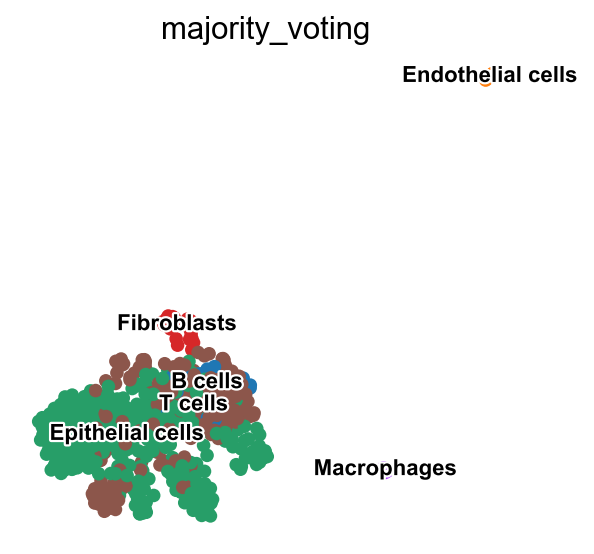

In [296]:
sc.pl.umap(adata, color = ['majority_voting'], legend_loc = 'on data', frameon=False, legend_fontsize=10, legend_fontoutline=2)

In [297]:
adata.obs

,sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,predicted_labels,majority_voting,conf_score,over_clustering
AAACGGGGTCGACTGC-1,SingleCell_1,517,517,596.0,2.0,0.335570,1,T cells,Epithelial cells,0.769694,41
AAACGGGGTCGGCACT-1,SingleCell_1,737,737,882.0,11.0,1.247166,1,Epithelial cells,Epithelial cells,0.167460,15
AAACGGGGTCGGCATC-1,SingleCell_1,1113,1113,1456.0,12.0,0.824176,1,Epithelial cells,Epithelial cells,0.896585,23
AAACGGGTCAGCCTAA-1,SingleCell_1,1931,1931,2828.0,8.0,0.282885,1,T cells,Epithelial cells,0.694926,23
AAACGGGTCGAACTGT-1,SingleCell_1,1620,1620,2804.0,23.0,0.820257,3,T cells,T cells,0.974327,0
...,...,...,...,...,...,...,...,...,...,...,...
TTTGCGCGTTTGTGTG-1,SingleCell_1,858,858,1163.0,37.0,3.181427,1,T cells,T cells,0.243447,36
TTTGGTTCAATTGCTG-1,SingleCell_1,377,377,2653.0,18.0,0.678477,0,T cells,T cells,0.324402,29
TTTGGTTGTCACCTAA-1,SingleCell_1,648,648,796.0,1.0,0.125628,3,T cells,T cells,0.748884,0
TTTGGTTTCGTAGGTT-1,SingleCell_1,1522,1522,2389.0,43.0,1.799916,2,Epithelial cells,Epithelial cells,0.977596,1


In [299]:
import pandas as pd
macrop = pd.DataFrame(adata.obs)
macrop.filter(items=["majority_voting", "conf_score"])
Macrophages = macrop.loc[macrop["majority_voting"]=="Endothelial cells", "conf_score"]

In [300]:
Macrophages.mean()

# Endothelial cells = 99.7% uhull
# B = 25%
# T = 42%
# Fibroblasto = 60%
# Cell epitelial = 60%
# Macrofagos = 37%

0.997837541265863

In [301]:
adata.obs["conf_score"].mean()

0.5193082658295325

In [302]:
model

CellTypist model with 32 cell types and 6639 features
    date: 2022-07-16 08:53:00.959521
    details: immune populations combined from 20 tissues of 18 studies
    source: https://doi.org/10.1126/science.abl5197
    version: v2
    cell types: B cells, B-cell lineage, ..., pDC precursor
    features: A1BG, A2M, ..., ZYX

In [303]:
model.cell_types

array(['B cells', 'B-cell lineage', 'Cycling cells', 'DC', 'DC precursor',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ETP',
       'Early MK', 'Endothelial cells', 'Epithelial cells',
       'Erythrocytes', 'Erythroid', 'Fibroblasts', 'Granulocytes',
       'HSC/MPP', 'ILC', 'ILC precursor', 'MNP', 'Macrophages',
       'Mast cells', 'Megakaryocyte precursor',
       'Megakaryocytes/platelets', 'Mono-mac', 'Monocyte precursor',
       'Monocytes', 'Myelocytes', 'Plasma cells', 'Promyelocytes',
       'T cells', 'pDC', 'pDC precursor'], dtype=object)

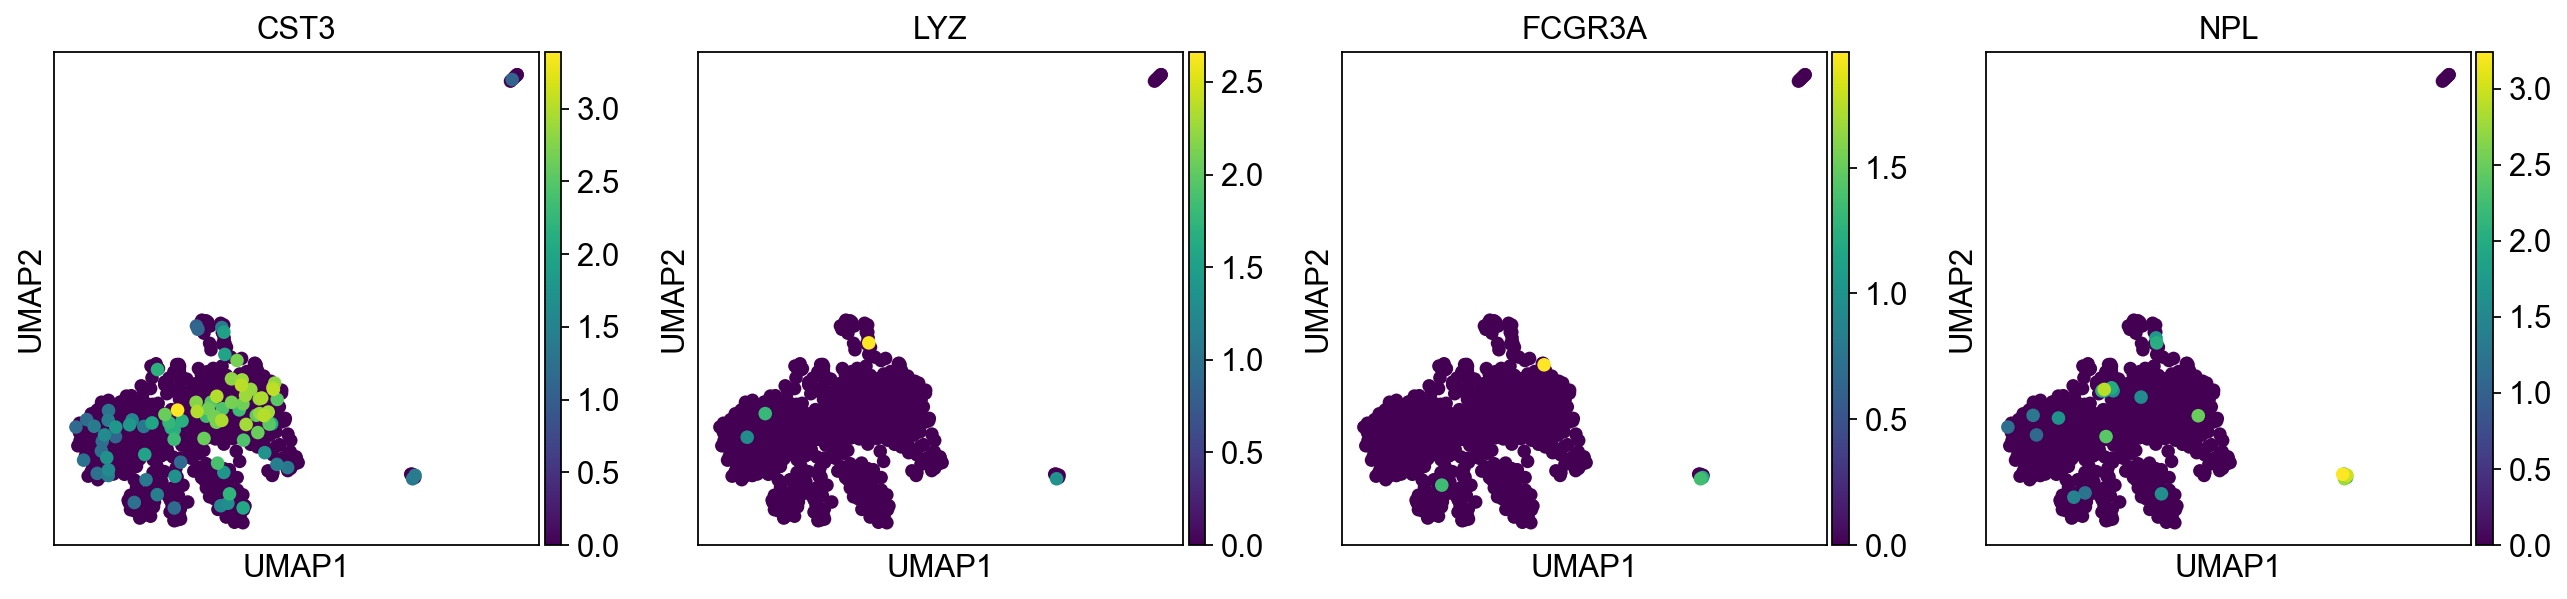

In [304]:
sc.pl.umap(adata, color=["CST3", "LYZ", 'FCGR3A', "NPL"])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_majority_voting']`


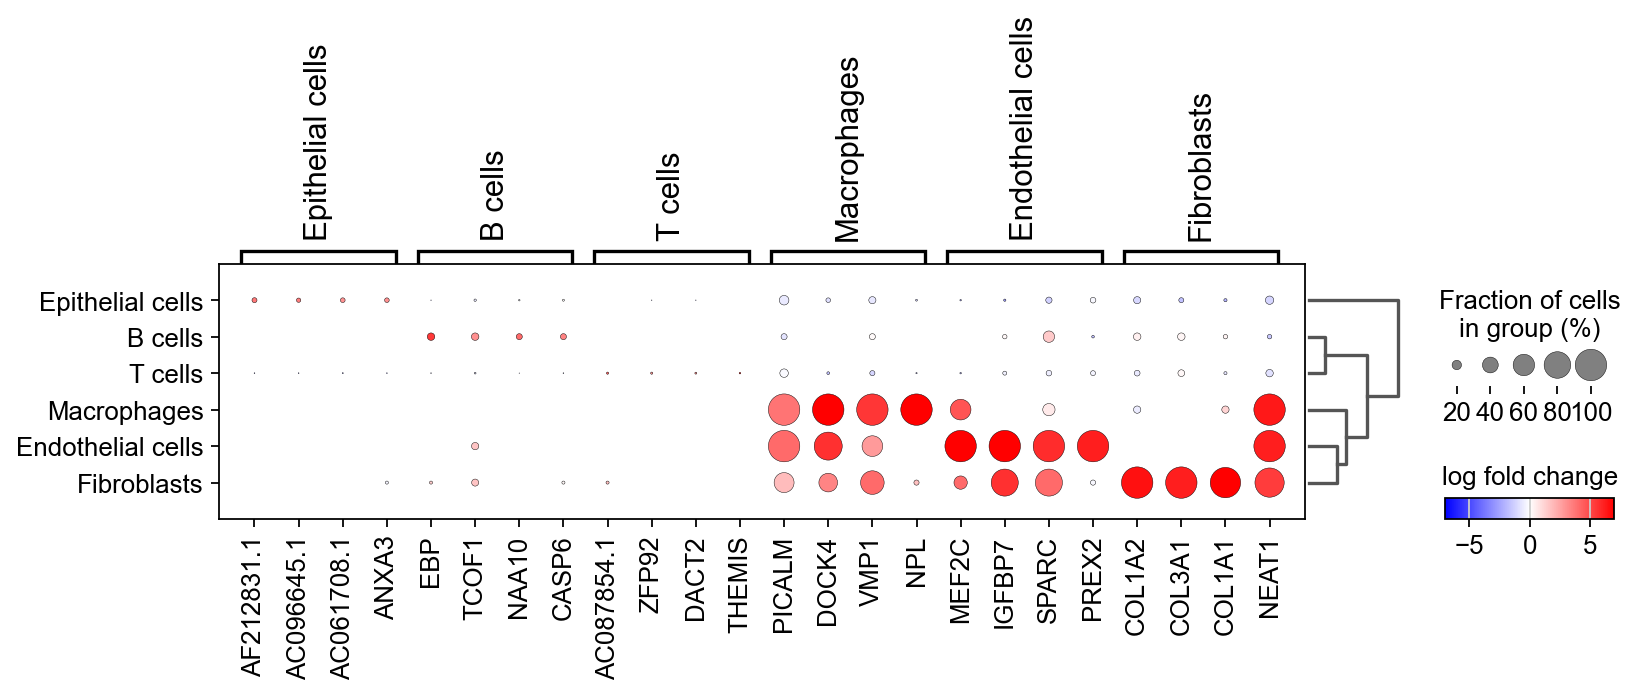

In [305]:
sc.tl.rank_genes_groups(adata, groupby="majority_voting")
sc.pl.rank_genes_groups_dotplot(adata, n_genes=4, values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr')

In [306]:
top_3_genes = model.extract_top_markers("Macrophages", 4)
top_3_genes = top_3_genes[1:4]
top_3_genes

array(['GNLY', 'LPL', 'PAQR5'], dtype=object)